In [1]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile

%matplotlib inline

from pymoo.algorithms.moo.nsga2 import NSGA2
from NSGAII import WIG20PortfolioOptimizationProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem

/tmp/ipykernel_11755/729697305.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
STOCK_QUOTATIONS_ARCHIVE_FILE_NAME = 'mstall.zip'
STOCK_NAMES_FILE_NAME = 'WIG20.txt'

In [3]:
def load_stock_quotations(stock_names, filename):
    s = {}
    with zipfile.ZipFile(filename) as z:
        for stock_name in stock_names:
            with z.open(stock_name + '.mst') as f:
                s[stock_name] = pd.read_csv(f, index_col='<DTYYYYMMDD>', parse_dates=True)[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]
                s[stock_name].index.rename('time', inplace=True)
                s[stock_name].rename(columns={'<OPEN>':'open', '<HIGH>':'high', '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'volume'}, inplace=True)
    return pd.concat(s.values(), keys=s.keys(), axis=1)

## 1. Notowania spółek giełdowych

In [4]:
stock_names = pd.read_csv(STOCK_NAMES_FILE_NAME, index_col=0, names=['stock name']).index.values
stock_names.sort()
number_of_stocks = len(stock_names)

In [5]:
stock_quotations = load_stock_quotations(stock_names, STOCK_QUOTATIONS_ARCHIVE_FILE_NAME).dropna()
stock_quotations
stock_quotations.tail()

ALIOR                                ASSECOPOL                \
             open   high    low  close    volume      open   high    low   
time                                                                       
2022-07-22  24.51  25.15  24.25  24.60  321881.0     75.05  76.10  74.20   
2022-07-25  24.51  25.30  24.50  24.83  231537.0     74.05  74.05  72.60   
2022-07-26  24.90  24.90  23.53  23.71  319609.0     72.75  73.95  72.55   
2022-07-27  23.95  24.13  23.11  23.30  276777.0     72.50  72.70  71.25   
2022-07-28  23.79  24.34  23.65  24.10  192856.0     72.35  72.95  71.70   

                            ...  SANPL                                 \
            close   volume  ...   open   high    low  close    volume   
time                        ...                                         
2022-07-22  74.50  30931.0  ...  227.0  233.8  227.0  230.0   32024.0   
2022-07-25  72.75  63801.0  ...  228.0  233.6  227.2  229.6   39668.0   
2022-07-26  72.80  49432.0  ...  227.8  229.8  220.0  222.6   76217.0   
2022-07-27  72.25  78441.0  ...  221.0  226.8  220.0  225.2   67340.0   
2022-07-28  72.80  49519.0  ...  226.4  238.0  223.0  229.2  139379.0   

           TAURONPE                                  
               open   high    low  close     volume  
time                                                 
2022-07-22    3.418  3.418  3.360  3.400   482156.0  
2022-07-25    3.399  3.405  3.324  3.330   943363.0  
2022-07-26    3.300  3.355  3.197  3.264  1986219.0  
2022-07-27    3.225  3.317  3.171  3.216  2231724.0  
2022-07-28    3.210  3.237  3.166  3.183  1287058.0  

[5 rows x 100 columns]

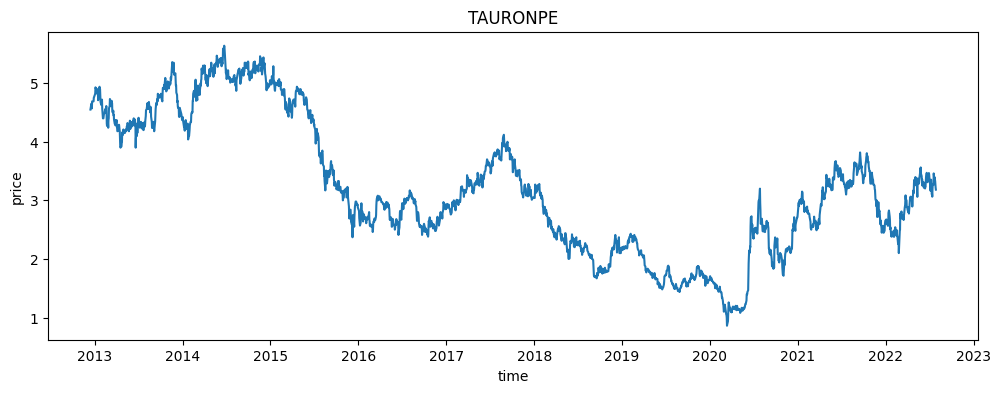

In [6]:
stock_name = 'TAURONPE'

plt.figure(figsize=(12, 4))
plt.plot(stock_quotations[stock_name]['close'].dropna())
plt.xlabel('time')
plt.ylabel('price')
plt.title(stock_name)
plt.show()

## 2. Stopy zwrotu spółek giełdowych

In [7]:
delta_t = 90
stock_returns = stock_quotations.xs('close', level=1, axis=1).pct_change()
returns_window = stock_returns[-delta_t-1:-1]
stock_returns_m = returns_window.mean()
stock_returns_s = returns_window.std()
stock_covariances = returns_window.cov()
stock_correlations = returns_window.corr()
negative_window = returns_window[returns_window < stock_returns_m]

stock_returns_sv = (negative_window - stock_returns_m).pow(2).mean()

### 2.1. Oczekiwana stopa zwrotu i ryzyko (określone przez wariancję stopy zwrotu) rozpatrywanych spółek

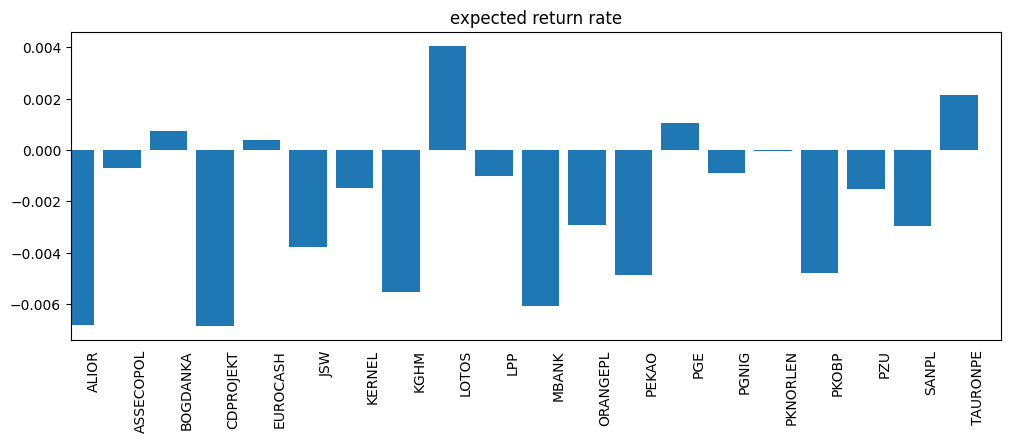

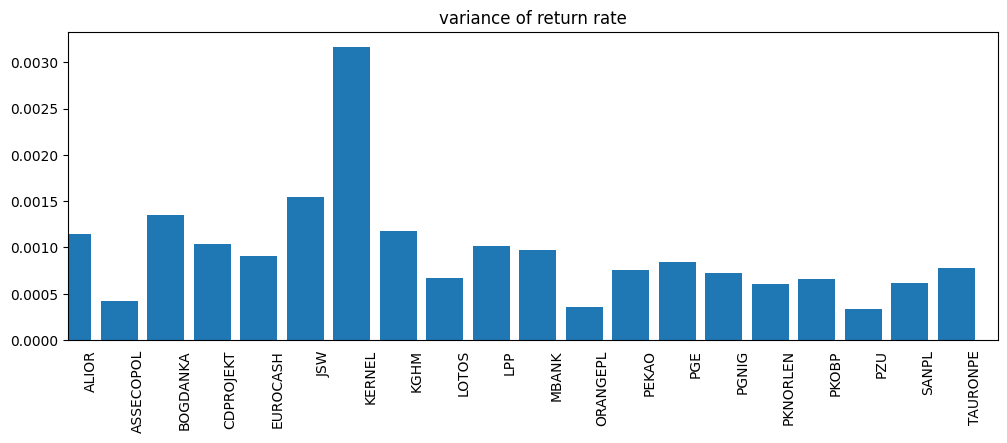

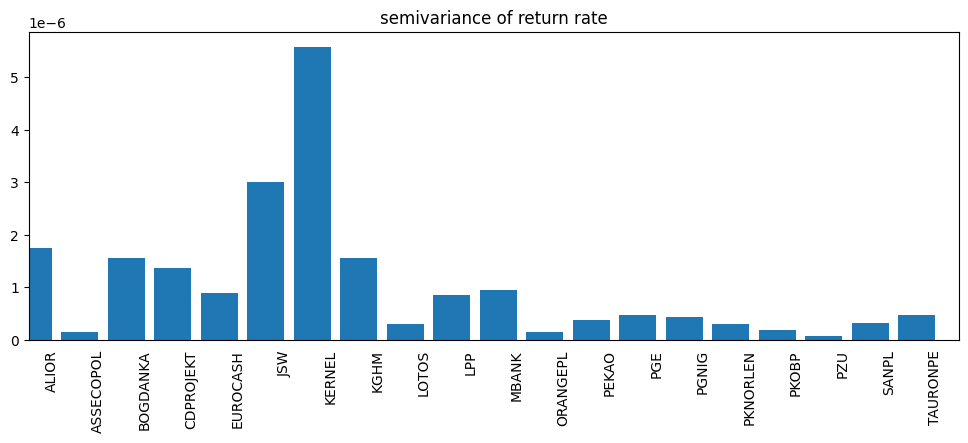

In [8]:
plt.figure(figsize=(12, 4))
plt.bar(np.arange(stock_returns_m.size)+0.1, stock_returns_m, 0.8)
plt.gca().xaxis.set_tick_params(width=0)
plt.xticks(np.arange(stock_returns_m.index.size)+0.5, stock_returns_m.index.values, rotation='vertical')
plt.xlim([0, stock_returns_m.size])
plt.title('expected return rate')
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(np.arange(stock_returns_s.size)+0.1, stock_returns_s**2, 0.8)
plt.gca().xaxis.set_tick_params(width=0)
plt.xticks(np.arange(stock_returns_s.index.size)+0.5, stock_returns_s.index.values, rotation='vertical')
plt.xlim([0, stock_returns_s.size])
plt.title('variance of return rate')
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(np.arange(stock_returns_sv.size)+0.1, stock_returns_sv**2, 0.8)
plt.gca().xaxis.set_tick_params(width=0)
plt.xticks(np.arange(stock_returns_sv.index.size)+0.5, stock_returns_sv.index.values, rotation='vertical')
plt.xlim([0, stock_returns_sv.size])
plt.title('semivariance of return rate')
plt.show()

### 2.2. Korelacja stóp zwrotu rozpatrywanych spółek

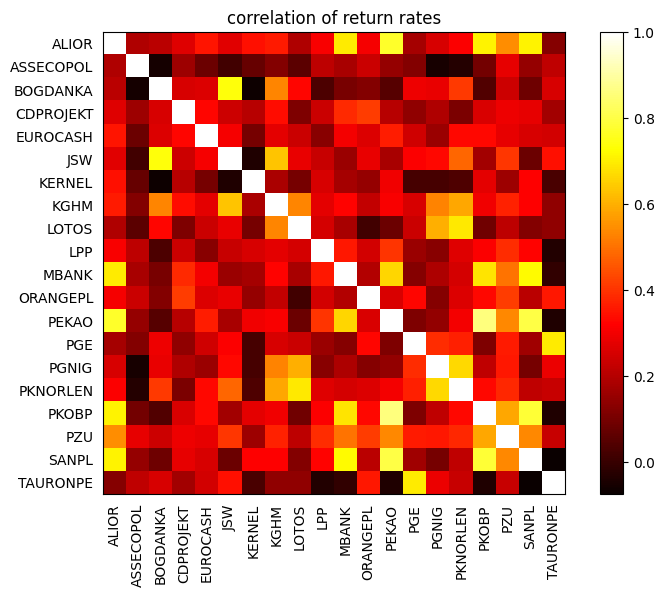

In [9]:
plt.figure(figsize=(9, 6))
plt.imshow(stock_correlations, cmap='hot', interpolation='none')
plt.colorbar()
plt.gca().xaxis.set_tick_params(width=0)
plt.xticks(np.arange(stock_correlations.columns.size), stock_correlations.columns.values, rotation='vertical')
plt.gca().yaxis.set_tick_params(width=0)
plt.yticks(np.arange(stock_correlations.columns.size), stock_correlations.columns.values, rotation='horizontal')
plt.title('correlation of return rates')
plt.show()

### 2.3. Spółki dominujące, zdominowane i niezdominowane

/tmp/ipykernel_11755/422077166.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (i != j) and (stock_returns_m[i] <= stock_returns_m[j]) and (stock_returns_s[i] > stock_returns_s[j]):


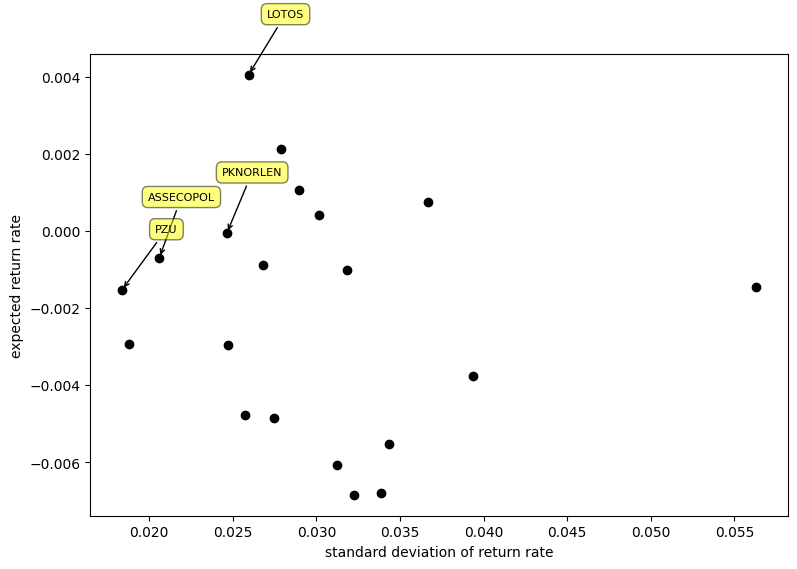

In [10]:
is_dominated = np.zeros(stock_returns_m.size)
for i in range(stock_returns_m.size):
    for j in range(stock_returns_m.size):
        if (i != j) and (stock_returns_m[i] <= stock_returns_m[j]) and (stock_returns_s[i] > stock_returns_s[j]):
            is_dominated[i] = 1
            break

plt.figure(figsize=(9, 6))
plt.scatter(stock_returns_s, stock_returns_m, color='#000000')
plt.xlabel('standard deviation of return rate')
plt.ylabel('expected return rate')
for i in range(stock_returns_m.size):
    if is_dominated[i] == 0:
        name = stock_returns_m.index.values[i]
        plt.annotate(
            name,
            xy = (stock_returns_s[name], stock_returns_m[name]), xytext = (40, 40),
            textcoords = 'offset points', ha = 'right', va = 'bottom', size = 8,
            bbox = dict(boxstyle = 'round, pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0'))
plt.show()

# 3. Optymalizacja portfela przy pomocy algorytmy NSGAII

In [11]:
problem = WIG20PortfolioOptimizationProblem(delta_t=90)

algorithm = NSGA2(pop_size=1000)

res = minimize(problem,
               algorithm,
               ('n_gen', 1000),
               seed=42,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |     1000 |      4 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |     2000 |      7 |  0.000000E+00 |  0.000000E+00 |  0.1366373717 |         ideal
     3 |     3000 |      4 |  0.000000E+00 |  0.000000E+00 |  0.6064934744 |         ideal
     4 |     4000 |     10 |  0.000000E+00 |  0.000000E+00 |  0.2119520151 |         ideal
     5 |     5000 |     10 |  0.000000E+00 |  0.000000E+00 |  0.1129020387 |         ideal
     6 |     6000 |      8 |  0.000000E+00 |  0.000000E+00 |  0.2272744523 |         ideal
     7 |     7000 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0595396572 |             f
     8 |     8000 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1524903614 |         ideal
     9 |     9000 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0825796261 |         ideal
    10 |    10000 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0627978321 |         ideal

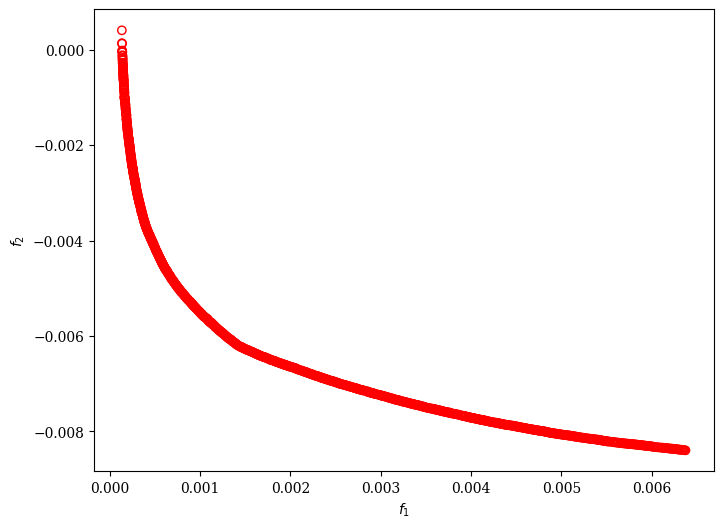

In [12]:
plot = Scatter()
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()
# plot.save("pareto_front.png")

In [13]:
sorted_indices = np.argsort(res.F[:, 0])
sorted_data = res.F[sorted_indices, :]
x, y = sorted_data[:, 0], -1*sorted_data[:, 1]

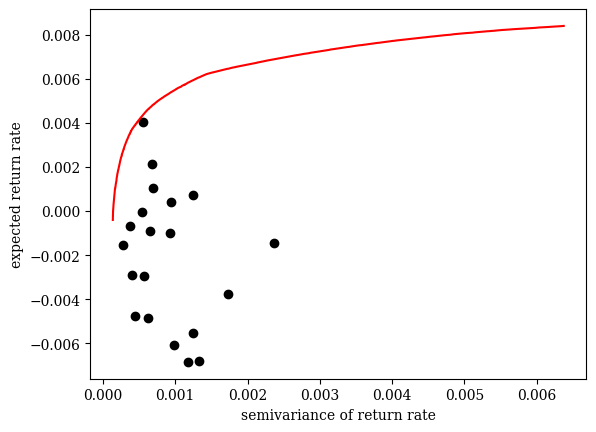

In [14]:
plt.plot(x, y, c='r')

plt.scatter(stock_returns_sv, stock_returns_m, color='#000000')
plt.xlabel('semivariance of return rate')
plt.ylabel('expected return rate')
plt.show()